In [11]:
# General
import numpy as np
import torch
import torch.nn.functional as F
from importlib import reload
from types import SimpleNamespace

# Custom
import data
reload(data)

import train
reload(train)

import modules
reload(modules)
from modules import GCN, GCN_GNNExplainer, GCN_GraphSVX
from modules import GraphSAGE
from torch_geometric.data import DataLoader
import torch.optim as optim

import GraphSVX_explainers
reload(GraphSVX_explainers)
from GraphSVX_explainers import GraphSVX, GraphLIME

# Training model

In [12]:
model, traindata, testdata, feature_names, target_names = train.train_GAT_GraphSVX(verbose = True)

n_sar_accs_train = traindata.y[traindata.y == 1].shape[0]
n_sar_accs_test = testdata.y[testdata.y == 1].shape[0]
print(f"Number of SARs in training set: {n_sar_accs_train} out of {traindata.y.shape[0]}")
print(f"Number of SARs in test set: {n_sar_accs_test} out of {testdata.y.shape[0]}")

Using device: cuda
Double check which dataset is being used.
Starting training with 400 epochs.
epoch: 10, loss: 166.0686, precision: 0.0915, recall: 0.7425
epoch: 20, loss: 196.3755, precision: 0.0930, recall: 0.8667
epoch: 30, loss: 176.2927, precision: 0.0929, recall: 0.9264
epoch: 40, loss: 140.1268, precision: 0.0910, recall: 0.9149
epoch: 50, loss: 80.6362, precision: 0.0906, recall: 0.7862
epoch: 60, loss: 50.2461, precision: 0.0873, recall: 0.5471
epoch: 70, loss: 39.3778, precision: 0.0906, recall: 0.4805
epoch: 80, loss: 36.8185, precision: 0.0885, recall: 0.4667
epoch: 90, loss: 34.3115, precision: 0.0879, recall: 0.4460
epoch: 100, loss: 32.6629, precision: 0.0858, recall: 0.4414
epoch: 110, loss: 32.1642, precision: 0.0836, recall: 0.4207
epoch: 120, loss: 26.7392, precision: 0.0839, recall: 0.4598
epoch: 130, loss: 26.8302, precision: 0.0849, recall: 0.5632
epoch: 140, loss: 28.3791, precision: 0.0887, recall: 0.7356
epoch: 150, loss: 25.2696, precision: 0.0885, recall: 0

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
with torch.no_grad():
    out = model.forward(testdata.x, testdata.edge_index)
    y_pred = out.cpu().numpy().argmax(axis=1)
    y_true = testdata.y.cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

[[ 320 4113]
 [  47  388]]


In [14]:
print(testdata.edge_index.shape)

torch.Size([2, 11210])


In [15]:
def get_sar_prediction_ix(model, testdata):
    model.eval()
    with torch.no_grad():
        out = model.forward(testdata.x, testdata.edge_index)
        y_pred = out.argmax(dim=1)
        sar_prediction_ix = torch.where(y_pred == 1)[0]
    return sar_prediction_ix

sar_prediction_ix = get_sar_prediction_ix(model, testdata)
n_sar_prediction_ix = len(sar_prediction_ix)

print(f'Some of the {n_sar_prediction_ix} SAR prediction indices: {sar_prediction_ix[0:5].cpu().numpy()} ...')

Some of the 4501 SAR prediction indices: [0 1 2 3 4] ...


[2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2]
[9, 7, 8, 14, 7, 8, 10, 8, 11, 9, 8, 9, 9, 17, 19, 13, 21, 21, 34, 70]
[2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2]
[9, 7, 8, 14, 7, 8, 10, 8, 11, 9, 8, 9, 9, 17, 19, 13, 21, 21, 34, 70]


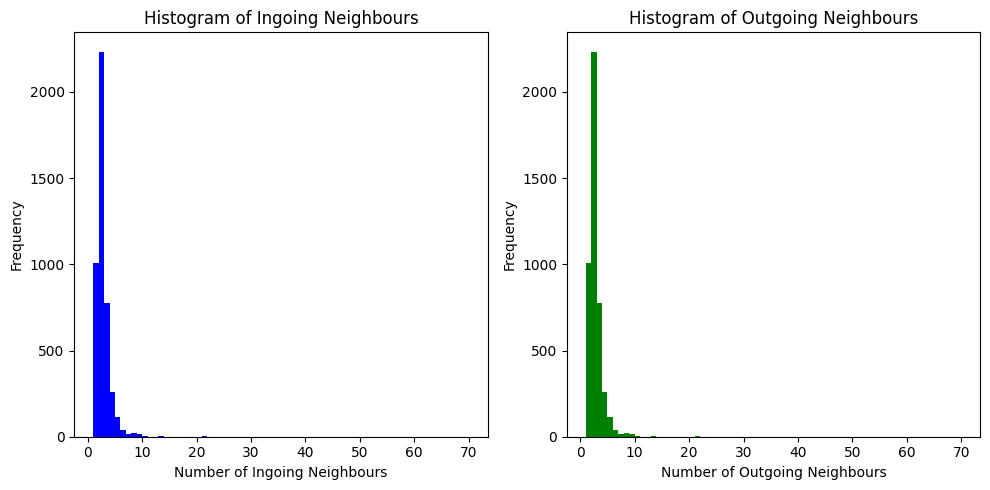

max number of outgoing neighbours: 70
max number of ingoing neighbours: 70


In [16]:
# Checking the number of ingoing (edges going towards the node v) and outgoing (edges going away from the node v) neighbours.

sar_prediction_n_outgoing_neighbours = []
sar_prediction_n_ingoing_neighbours = []
for count, v in enumerate(sar_prediction_ix):
    outgoing_neighbour_ix = torch.where(testdata.edge_index[0] == v)
    ingoing_neighbour_ix = torch.where(testdata.edge_index[1] == v)
    outgoing_neighbour_ix = testdata.edge_index[1][outgoing_neighbour_ix]
    ingoing_neighbour_ix = testdata.edge_index[0][ingoing_neighbour_ix]
    n_outgoing_neighbours = len(outgoing_neighbour_ix)
    n_ingoing_neighbours = len(ingoing_neighbour_ix)
    sar_prediction_n_outgoing_neighbours.append(n_outgoing_neighbours)
    sar_prediction_n_ingoing_neighbours.append(n_ingoing_neighbours)

n_check = 20
print(sar_prediction_n_ingoing_neighbours[:n_check])
print(sar_prediction_n_ingoing_neighbours[-n_check:])
print(sar_prediction_n_outgoing_neighbours[:n_check])
print(sar_prediction_n_outgoing_neighbours[-n_check:])

import matplotlib.pyplot as plt

data_range_outgoing = max(sar_prediction_n_outgoing_neighbours) - min(sar_prediction_n_outgoing_neighbours)
data_range_ingoing = max(sar_prediction_n_ingoing_neighbours) - min(sar_prediction_n_ingoing_neighbours)

plt.figure(figsize=(10, 5))

# Histogram for outgoing_neighbours
plt.subplot(1, 2, 2)
plt.hist(sar_prediction_n_outgoing_neighbours, bins=data_range_outgoing, color='green')
plt.xlabel('Number of Outgoing Neighbours')
plt.ylabel('Frequency')
plt.title('Histogram of Outgoing Neighbours')

# Histogram for ingoing_neighbours
plt.subplot(1, 2, 1)
plt.hist(sar_prediction_n_ingoing_neighbours, bins=data_range_ingoing, color='blue')
plt.xlabel('Number of Ingoing Neighbours')
plt.ylabel('Frequency')
plt.title('Histogram of Ingoing Neighbours')

plt.tight_layout()
plt.show()

print(f'max number of outgoing neighbours: {max(sar_prediction_n_outgoing_neighbours)}')
print(f'max number of ingoing neighbours: {max(sar_prediction_n_ingoing_neighbours)}')

# Applying GraphSVX

In [22]:
# 318, interesting node
# Printing info about the explained node
node_to_explain = sar_prediction_ix[-10].item()
print(f'Explaining node {node_to_explain} which was prediced SAR.')
print(f'The node was predicted SAR (label 1) with probability {model.forward(testdata.x, testdata.edge_index)[node_to_explain].exp()[1].item():.4f}.')
print(f'The true label is {testdata.y[node_to_explain]}.\n')

# Running the explainer
testdata = testdata.to('cpu')
model = model.to('cpu')

data = SimpleNamespace()
data.x = testdata.x
data.edge_index  = testdata.edge_index
data.y = testdata.y
data.num_classes = 2
data.num_features = 10
data.num_nodes = testdata.x.shape[0]
data.name = 'test'

explainer = GraphSVX(data, model, True)
explanations = explainer.explain(node_indexes=[node_to_explain], num_samples=100, hops = 3)

model = model.to('cuda:0')
testdata = testdata.to('cuda:0')

Explaining node 4858 which was prediced SAR.
The node was predicted SAR (label 1) with probability 1.0000.
The true label is 0.



100it [00:03, 27.01it/s]


WLS: Matrix not invertible
r2:  0.3479970719255048
weighted r2:  0.999921452550722
Explanations include 7 node features and 60 neighbours for this node        for 2 classes
Model prediction is class 1 with confidence 0.9999862909317017, while true label is 0
Base value 0.5285297209246735 for class  1
Weights for node features:  -0.05052284597149992 and neighbours:  0.5219843435370422
Most influential features:  1 and neighbours 5
Most influential features:  [(0, -0.32855987548828125), (2, 0.22088070929748937), (9, 0.0643734335899353)]
Most influential neighbours:  [(4516, -0.9408726692199707), (529, 0.44078314304351807), (756, 0.2690655130936648)]
Time:  4.519685506820679


In [23]:
from collections import deque
from torch_geometric.data import Data


def build_subgraph(data, node_to_explain, layers=2):
    edge_index = data.edge_index
    nodes = [node_to_explain]
    
    queue = deque([(node_to_explain, 0)])  # Initialize queue with starting node and its depth
    visited=[]
    edges=[]
    while queue!=deque([]):
        print(queue)
        node, depth = queue.popleft()
        if depth==layers:
            break
        visited.append(node)
        print('popped node',node)
        #src and dst neighbors
        src = edge_index[1][edge_index[0]==node].tolist()
        dst = edge_index[0][edge_index[1]==node].tolist()
        neighbors = list(set(src+dst))

        #Add edges to edges list
        for n in neighbors:
            if (node,n) not in edges and (n,node) not in edges:
                edges.append((node,n))

            if n not in visited:
                visited.append(n)
                nodes.append(n)
                queue.extend([(n,depth+1)])
    
    
    nodes = torch.tensor(nodes)
    edges = torch.tensor(edges).t().contiguous()   

    org_to_new_mapping, new_to_org_mapping, edges = node_index_mapping(nodes,edges)

    #find feature vectors for nodes
    node_features = data.x[nodes]

    #create data object for subgraph using node_fetures and edges
    data = Data(x=node_features, edge_index=edges)

    return data, org_to_new_mapping, new_to_org_mapping


def node_index_mapping(nodes,edges):

    # Create a mapping from original node indices to new indices
    node_index_mapping = {(old_idx.item(), new_idx) for new_idx, old_idx in enumerate(nodes)}

    # Create a dictionary mapping original indices to new indices
    org_to_new_mapping = {old_idx: new_idx for old_idx, new_idx in node_index_mapping}

    # Create a dictionary mapping new indices to original indices
    new_to_org_mapping = {new_idx: old_idx for old_idx, new_idx in node_index_mapping}

    # Update the edge indices to use the new node indices
    for old_idx, new_idx in node_index_mapping:
        edges[edges == old_idx] = new_idx

    return org_to_new_mapping, new_to_org_mapping, edges

data, org_to_new_mapping, new_to_org_mapping=build_subgraph(testdata, node_to_explain, 3)

print(data.edge_index)
# find new index for node_to_explain

# Use org_to_new_mapping to map from original indices to new indices
new_index = org_to_new_mapping.get(311)
print(new_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data.edge_index = data.edge_index.to(device)

deque([(4858, 0)])
popped node 4858
deque([(805, 1), (4006, 1), (4842, 1), (4207, 1), (432, 1), (562, 1), (2165, 1), (2232, 1)])
popped node 805
deque([(4006, 1), (4842, 1), (4207, 1), (432, 1), (562, 1), (2165, 1), (2232, 1), (3336, 2), (4524, 2)])
popped node 4006
deque([(4842, 1), (4207, 1), (432, 1), (562, 1), (2165, 1), (2232, 1), (3336, 2), (4524, 2), (756, 2), (934, 2)])
popped node 4842
deque([(4207, 1), (432, 1), (562, 1), (2165, 1), (2232, 1), (3336, 2), (4524, 2), (756, 2), (934, 2), (226, 2), (2499, 2), (4516, 2), (11, 2), (3630, 2), (720, 2), (241, 2), (2009, 2), (155, 2)])
popped node 4207
deque([(432, 1), (562, 1), (2165, 1), (2232, 1), (3336, 2), (4524, 2), (756, 2), (934, 2), (226, 2), (2499, 2), (4516, 2), (11, 2), (3630, 2), (720, 2), (241, 2), (2009, 2), (155, 2), (529, 2), (4725, 2)])
popped node 432
deque([(562, 1), (2165, 1), (2232, 1), (3336, 2), (4524, 2), (756, 2), (934, 2), (226, 2), (2499, 2), (4516, 2), (11, 2), (3630, 2), (720, 2), (241, 2), (2009, 2), (15

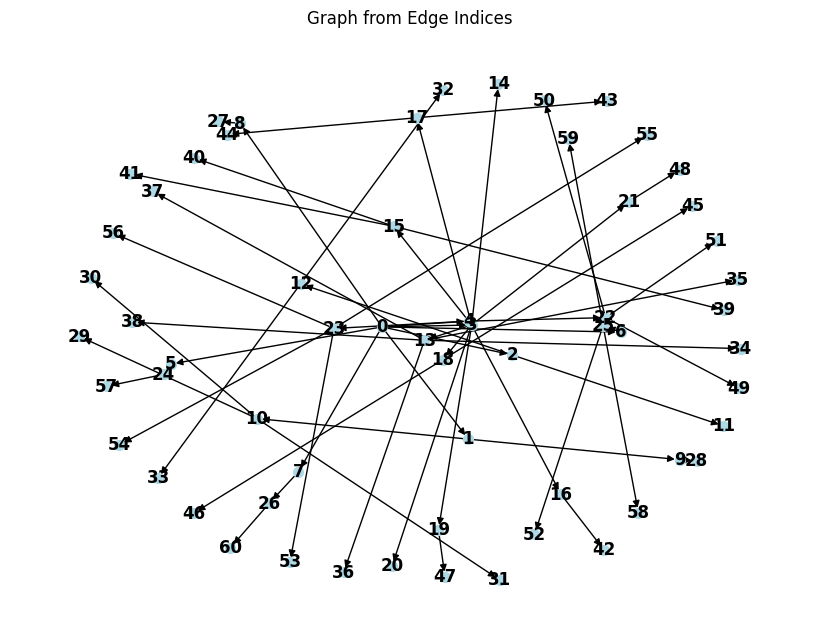

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
G = to_networkx(data)

# Node coloring
color_map = []
for node in G:
    if node < 10:
        color_map.append('blue')
    else: 
        color_map.append('green')

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=50, font_size=12, font_weight='bold')
plt.title('Graph from Edge Indices')
plt.show()